# Minecraft Playtime Analysis

This project explores the relationship between demographic variables (age and gender) and the total number of play hours in Minecraft. The goal is to predict which demographic groups contribute the highest playtime, focusing on younger males as a hypothesized high-playtime group.


In [1]:

# Load necessary libraries
library(tidyverse)
library(tidymodels)

# Load data
players <- read_csv("https://raw.githubusercontent.com/nelka-kim/plaicraft_project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/nelka-kim/plaicraft_project/refs/heads/main/sessions.csv")

# Display the structure of the datasets
glimpse(players)
glimpse(sessions)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Rows: 196
Columns: 9
$ experience       <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "A…
$ subscribe        <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRU…
$ hashedEmail      <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee97…
$ played_hours     <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.…
$ name             <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Ad…
$ gender           <chr> "Male", "Male", "Male", "Female", "Male", "Female", "…
$ age              <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22…
$ individualId     <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ organizationName <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/2

### Data Overview
We load and inspect the two datasets: `players.csv` and `sessions.csv`, which contain player details and session time logs, respectively. The primary variables of interest are `age`, `experience`, and `played_hours`.


In [2]:

# Summarize and prepare data
players_summarized <- players %>%
  group_by(hashedEmail) %>%
  summarize(total_played_hours = sum(played_hours, na.rm = TRUE))

# Merge and select relevant columns
players_final <- players %>%
  left_join(players_summarized, by = "hashedEmail") %>%
  select(hashedEmail, total_played_hours, age, experience)

# Display the first few rows of the prepared data
head(players_final)


hashedEmail,total_played_hours,age,experience
<chr>,<dbl>,<dbl>,<chr>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,9,Pro
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,17,Veteran
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,17,Veteran
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,21,Amateur
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,21,Regular
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,17,Amateur


### Visualizing Relationships

We will sample 100 players and explore the relationship between their `age` and `total_played_hours`.

#### Scatter Plot: Age vs Total Played Hours
The scatter plot helps us understand the relationship between age and playtime.


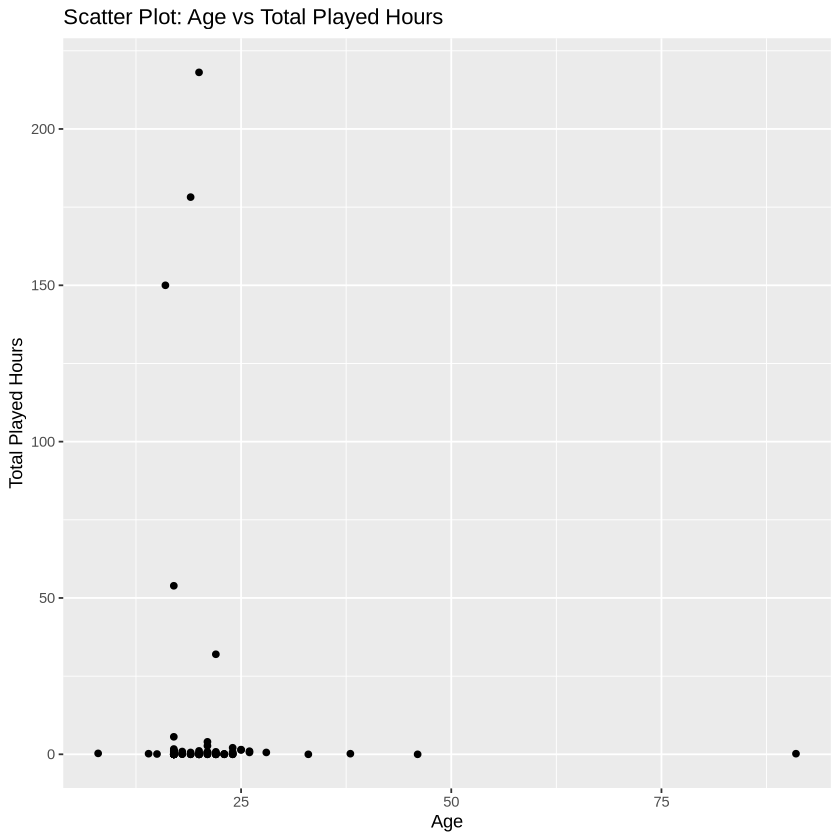

In [3]:

# Sample 100 players
set.seed(123)
players_100 <- players_final %>% sample_n(100)

# Scatter plot for Age vs Total Played Hours
library(ggplot2)
ggplot(players_100, aes(x = age, y = total_played_hours)) +
  geom_point() +
  labs(
    title = "Scatter Plot: Age vs Total Played Hours",
    x = "Age",
    y = "Total Played Hours"
  )


#### Age Distribution - Histogram
Let's visualize the distribution of player ages to understand the population density across different age groups.


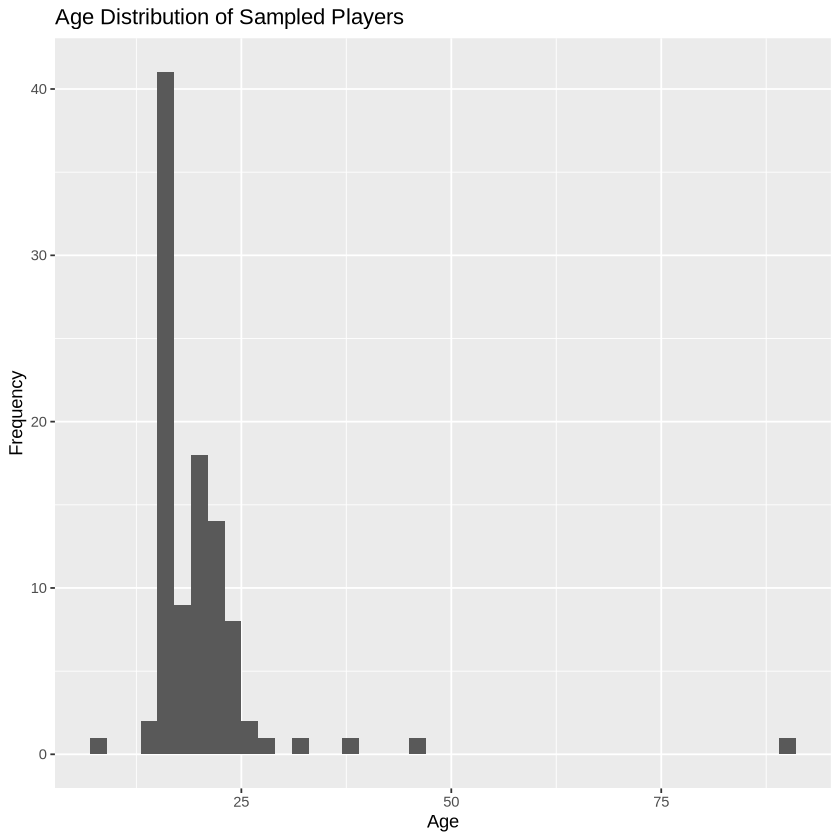

In [4]:

# Age Distribution
ggplot(players_100, aes(x = age)) +
  geom_histogram(binwidth = 2) +
  labs(
    title = "Age Distribution of Sampled Players",
    x = "Age",
    y = "Frequency"
  )


### Model Training and Evaluation

We will perform a K-Nearest Neighbors (KNN) regression to predict total play hours based on age. We will split the data into training and testing sets, and use 4-fold cross-validation for model evaluation.

#### KNN Model
We start by tuning the number of neighbors (`k`) to identify the optimal value.


In [5]:

# Train-test split
set.seed(123)
players_split <- initial_split(players_final, prop = 0.75, strata = total_played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

# Specify KNN model
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

# Recipe for preprocessing
players_recipe <- recipe(total_played_hours ~ age, data = players_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())


#### Optimal k Selection

We will use cross-validation to tune `k` and select the value that minimizes the root mean squared error (RMSE).


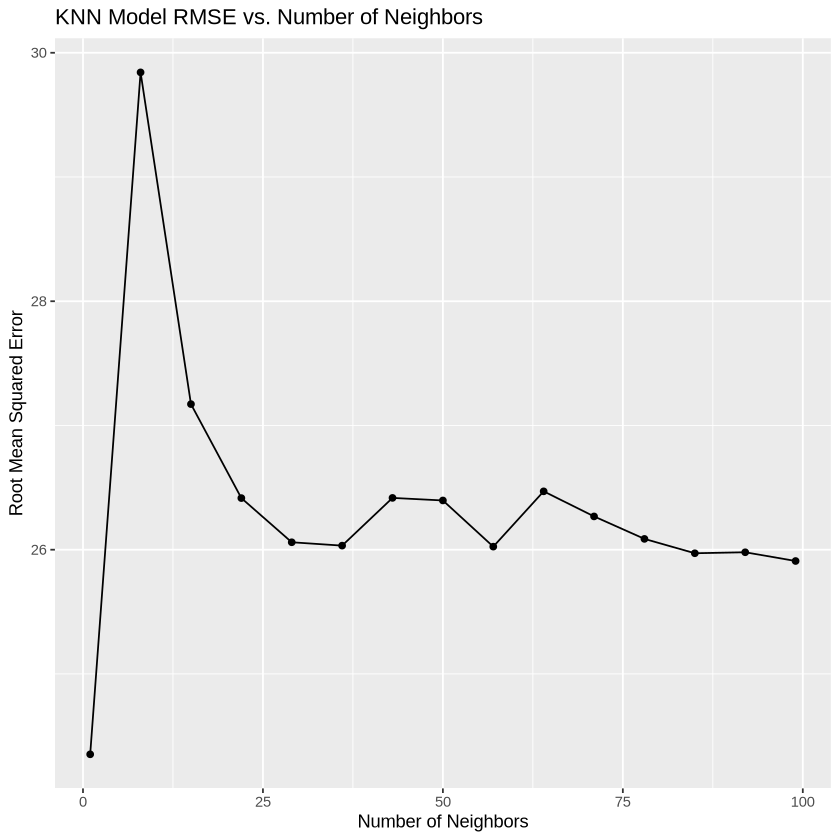

In [6]:

# Cross-validation
set.seed(123)
players_vfold <- vfold_cv(players_training, v = 4, strata = total_played_hours)

# Workflow
players_workflow <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(players_spec)

# Grid search for tuning
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 7))
players_results <- players_workflow %>%
  tune_grid(resamples = players_vfold, grid = gridvals) %>%
  collect_metrics() %>%
  filter(.metric == "rmse")

# Plot RMSE vs. Number of Neighbors
ggplot(players_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    title = "KNN Model RMSE vs. Number of Neighbors",
    x = "Number of Neighbors",
    y = "Root Mean Squared Error"
  )


#### Final Model Evaluation
Based on the cross-validation results, the optimal number of neighbors `k=15` is chosen for the final model. We will then evaluate the model on the test data and plot the predictions.


In [7]:

# Fit final model with optimal k
k_min <- players_results %>%
  filter(mean == min(mean)) %>%
  pull(neighbors)

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
  set_engine("kknn") %>%
  set_mode("regression")

best_fit <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(best_spec) %>%
  fit(data = players_training)

# Evaluate on test data
players_predictions <- best_fit %>%
  predict(players_testing) %>%
  bind_cols(players_testing)

metrics(players_predictions, truth = total_played_hours, estimate = .pred)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.210564e+01
rsq,standard,4.589188e-04
mae,standard,4.946000e+00


#### Final Predictions - Age vs. Predicted Play Hours
The final plot shows the relationship between age and predicted play hours using the optimal model.


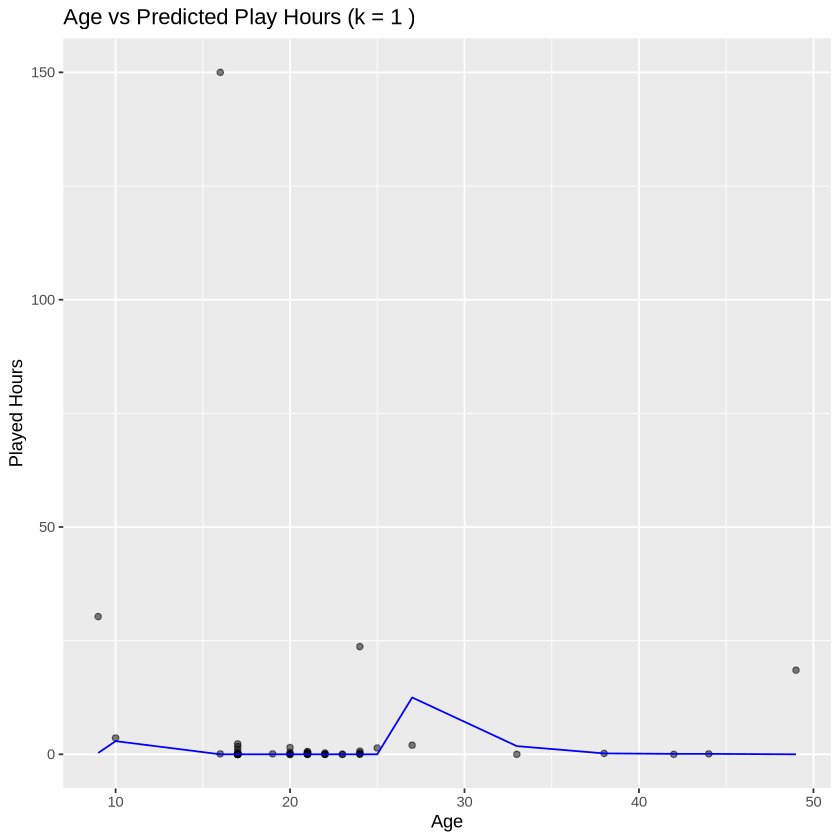

In [8]:

# Plot Final Predictions
ggplot(players_predictions, aes(x = age, y = total_played_hours)) +
  geom_point(alpha = 0.5) +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    title = paste("Age vs Predicted Play Hours (k =", k_min, ")"),
    x = "Age",
    y = "Played Hours"
  )
